### Import packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.patches as mpatches


### Data understanding

In [43]:
### Reading the dataset
# Ensure the file path is correct and the file exists
# Adjust the path as necessary for your environment
# Example: df = pd.read_csv('path_to_your_file.csv', delimiter=';
df = pd.read_csv('/Users/camhabui/Documents/Thesis/final.csv', delimiter=';')
df.head()

,week_date,total_sales,cost_iron,cost_aluminum,cost_energy,cost_production,fx_rate,ev_sales,export_value,quantity
0,28/12/2020,"10932393,89","1,39","1645,84","0,0646","238,2905","1,2271",79409,1639131999,140469
1,04/01/2021,"3686279,86","1,39","1645,84","0,0646","238,2905","1,2296",79409,1639131999,46887
2,11/01/2021,"8965000,12","1,39","1645,84","0,0646","238,2905","1,2163",79409,1639131999,183792
3,18/01/2021,"11766983,19","1,39","1645,84","0,0646","238,2905","1,2064",79409,1639131999,231777
4,25/01/2021,"4926779,37","1,39","1645,84","0,0646","238,2905","1,2152",79409,1639131999,179196


In [44]:
### Ensure the 'week_date' column is in the correct format
df['week_date'] = pd.to_datetime(df['week_date'], format='%d/%m/%Y')
df.set_index('week_date', inplace=True) ### Set it as the index

In [45]:
### Function to replaces ',' with '.' and converts specified columns to float, depending if they are numeric
def convert_columns_to_float(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)
    return df

In [46]:
### Convert specified columns to float
columns_to_convert = ['total_sales', 'cost_iron', 'cost_aluminum', 'cost_energy',
      'cost_production', 'fx_rate', 'ev_sales', 'export_value', 'quantity']
df = convert_columns_to_float(df, columns_to_convert) 

### DATA  Analysis 

In [47]:
### Select the 'total_sales' column for further analysis
# This is the target variable we will be forecasting
df_use = df['total_sales']
# Turning df_use into a DataFrame with only the 'total_sales' column
df_use = pd.DataFrame(df_use)

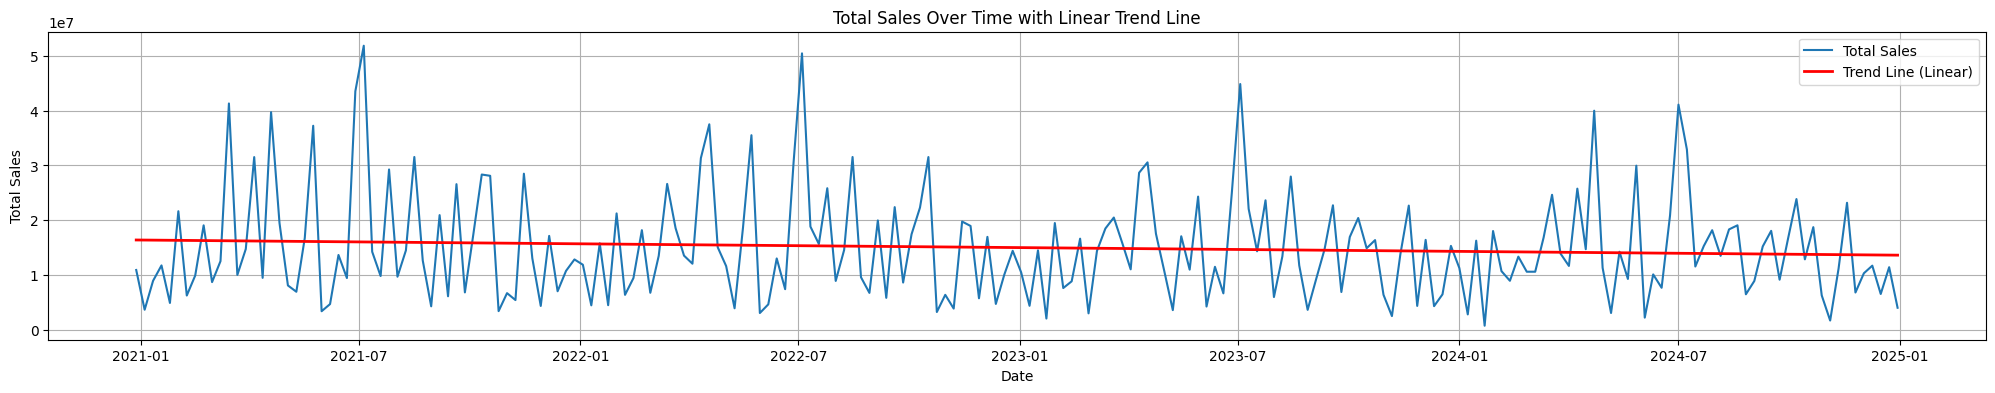

In [48]:
### Draw a time series plot of the total sales with a linear trend line
# Ensure the index is sorted by date
df_use = df_use.sort_index()

# Create a numeric time index for regression
df_use['time_index'] = range(len(df_use))

# Fit a linear regression model for the trend
model = LinearRegression()
model.fit(df_use[['time_index']], df_use['total_sales'])
df_use['trend'] = model.predict(df_use[['time_index']])

# Plot total sales and the trend line
plt.figure(figsize=(25, 4))
plt.plot(df_use.index, df_use['total_sales'], label='Total Sales')
plt.plot(df_use.index, df_use['trend'], color='red', linewidth=2, label='Trend Line (Linear)')
plt.title('Total Sales Over Time with Linear Trend Line')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
df_use['year'] = df_use.index.year
df_use['week'] = df_use.index.isocalendar().week
df_use = df_use.iloc[1:-1]

In [50]:
df_use 

,total_sales,time_index,trend,year,week
week_date,,,,,
2021-01-04,3686279.86,1,1.638998e+07,2021,1
2021-01-11,8965000.12,2,1.637675e+07,2021,2
2021-01-18,11766983.19,3,1.636351e+07,2021,3
2021-01-25,4926779.37,4,1.635028e+07,2021,4
2021-02-01,21646899.18,5,1.633705e+07,2021,5
...,...,...,...,...,...
2024-11-25,6827167.31,204,1.370353e+07,2024,48
2024-12-02,10336712.38,205,1.369029e+07,2024,49
2024-12-09,11722276.42,206,1.367706e+07,2024,50


In [51]:
#df_use = df_use.iloc[1:-1]

In [52]:
df_use 

,total_sales,time_index,trend,year,week
week_date,,,,,
2021-01-04,3686279.86,1,1.638998e+07,2021,1
2021-01-11,8965000.12,2,1.637675e+07,2021,2
2021-01-18,11766983.19,3,1.636351e+07,2021,3
2021-01-25,4926779.37,4,1.635028e+07,2021,4
2021-02-01,21646899.18,5,1.633705e+07,2021,5
...,...,...,...,...,...
2024-11-25,6827167.31,204,1.370353e+07,2024,48
2024-12-02,10336712.38,205,1.369029e+07,2024,49
2024-12-09,11722276.42,206,1.367706e+07,2024,50


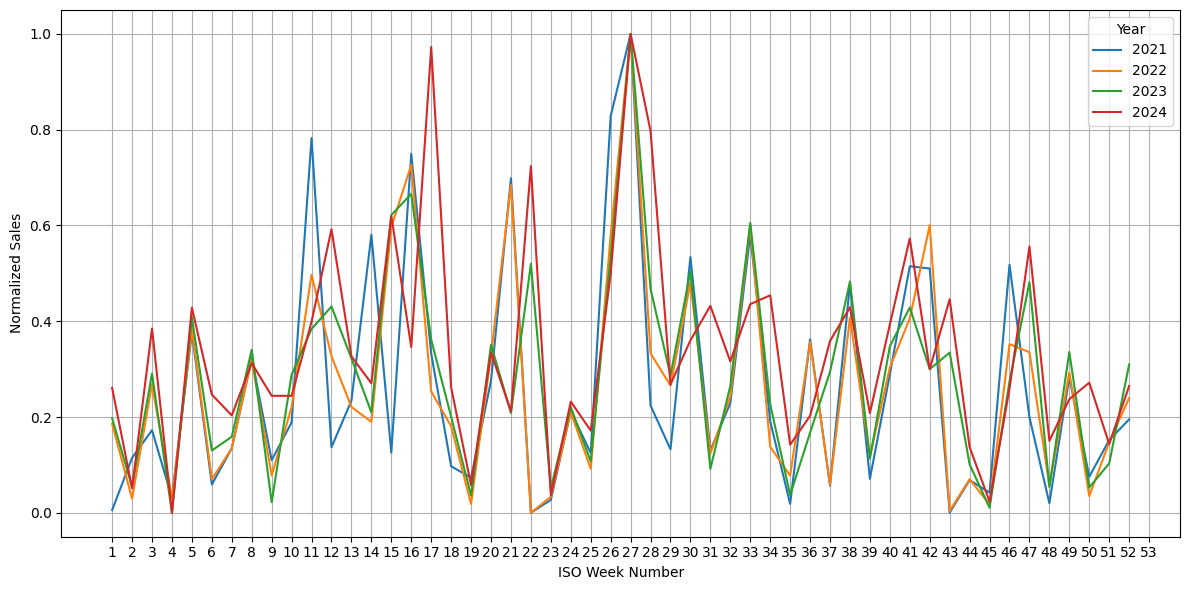

In [53]:
### Normalize the total sales within each year
# This will allow us to compare the sales movement across different years
df_use['normalized_sales'] = df_use.groupby('year')['total_sales'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Plot normalized sales per ISO week for each year
plt.figure(figsize=(12, 6))
for year in df_use['year'].unique():
    subset = df_use[df_use['year'] == year]
    plt.plot(subset['week'], subset['normalized_sales'], label=str(year))

#plt.title("Normalized Weekly Sales Movement Compared Across Years")
plt.xlabel("ISO Week Number")
plt.ylabel("Normalized Sales")
plt.xticks(range(1, 54))
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
# Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
# This test will help us determine if the time series is stationary or not
from statsmodels.tsa.stattools import adfuller
import pandas as pd

#ADF test
result = adfuller(df_use['total_sales'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("The series is stationary (reject H0).")
else:
    print("The series is non-stationary (fail to reject H0).")


ADF Statistic: -5.175406
p-value: 0.000010
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575
The series is stationary (reject H0).


## STL 

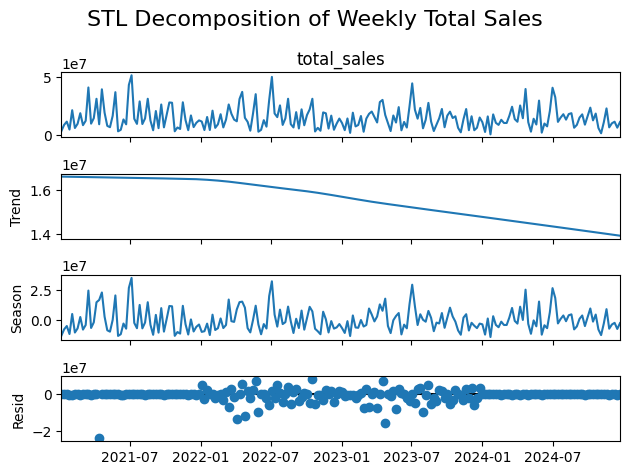

In [55]:
# Perform STL decomposition to analyze the seasonal and trend components of the time series
# Apply STL decomposition
stl = STL(df_use['total_sales'], period=52, robust=True)
result = stl.fit()

# Plot the decomposition
result.plot()
plt.suptitle("STL Decomposition of Weekly Total Sales", fontsize=16)
plt.tight_layout()
plt.show()


In [56]:
# Calculate the strength of seasonality using the variance of the seasonal and residual components
# Extract seasonal and residual components
seasonal = result.seasonal
residual = result.resid

# Compute variances
var_resid = np.var(residual, ddof=1)
var_seasonal_plus_resid = np.var(seasonal + residual, ddof=1)

# Seasonality strength
seasonality_strength = 1 - (var_resid / var_seasonal_plus_resid)
print(f"Seasonality Strength: {seasonality_strength:.4f}")

if seasonality_strength > 0.5:
    print("The time series shows strong seasonality.")
else:
    print("The time series shows weak seasonality.")

Seasonality Strength: 0.8828
The time series shows strong seasonality.


### Signal construction


In [57]:
from scipy.signal import savgol_filter

In [58]:
# STEP 1: Smooth seasonal component
smoothed_seasonal = pd.Series(
    savgol_filter(seasonal.values, window_length=11, polyorder=2),
    index=seasonal.index)
# STEP 2: Calculate the first difference of the smoothed seasonal component
derivative = smoothed_seasonal.diff().fillna(0)
derivative_smoothed = derivative.rolling(window=5, center=True).mean().fillna(0)

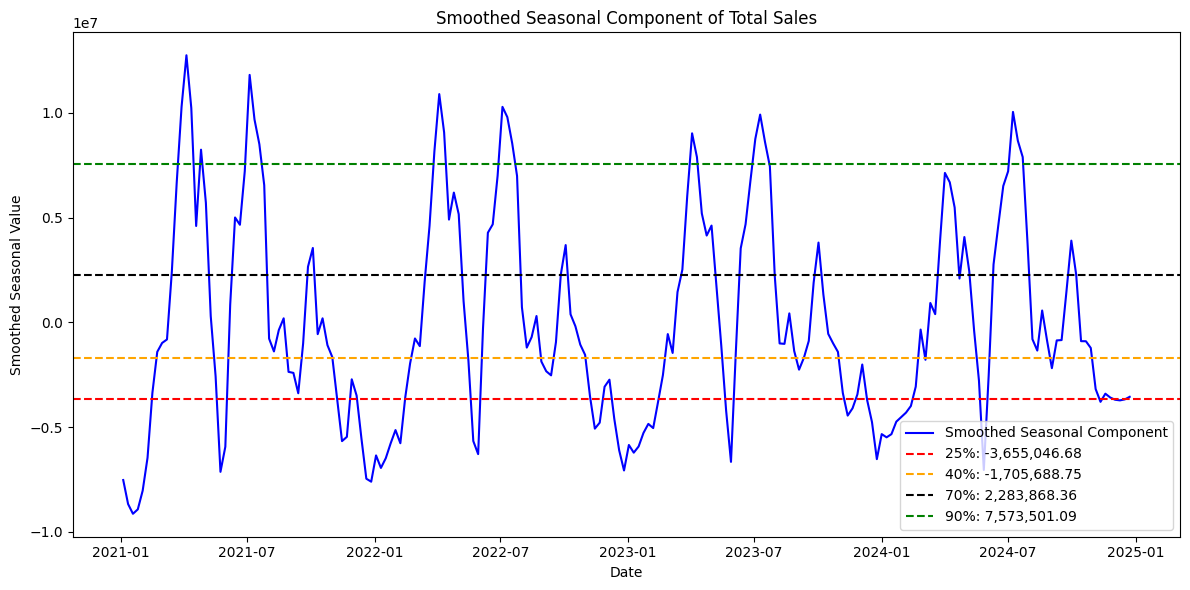

In [59]:
## Calculate quantiles for the smoothed seasonal component
q25 = smoothed_seasonal.quantile(0.25)
q40 = smoothed_seasonal.quantile(0.40)
q70 = smoothed_seasonal.quantile(0.70)
q90 = smoothed_seasonal.quantile(0.90)
#Plot the smoothed seasonal component
plt.figure(figsize=(12, 6))
plt.plot(smoothed_seasonal.index, smoothed_seasonal, label='Smoothed Seasonal Component', color='blue')
plt.title('Smoothed Seasonal Component of Total Sales')
plt.xlabel('Date')
plt.ylabel('Smoothed Seasonal Value')


plt.axhline(y=q25, color='red', linestyle='--', label=f'25%: {q25:,.2f}')
plt.axhline(y=q40, color='orange', linestyle='--', label=f'40%: {q40:,.2f}')
plt.axhline(y=q70, color='black', linestyle='--', label=f'70%: {q70:,.2f}')
plt.axhline(y=q90, color='green', linestyle='--', label=f'90%: {q90:,.2f}')

plt.legend()
plt.tight_layout()
plt.show()




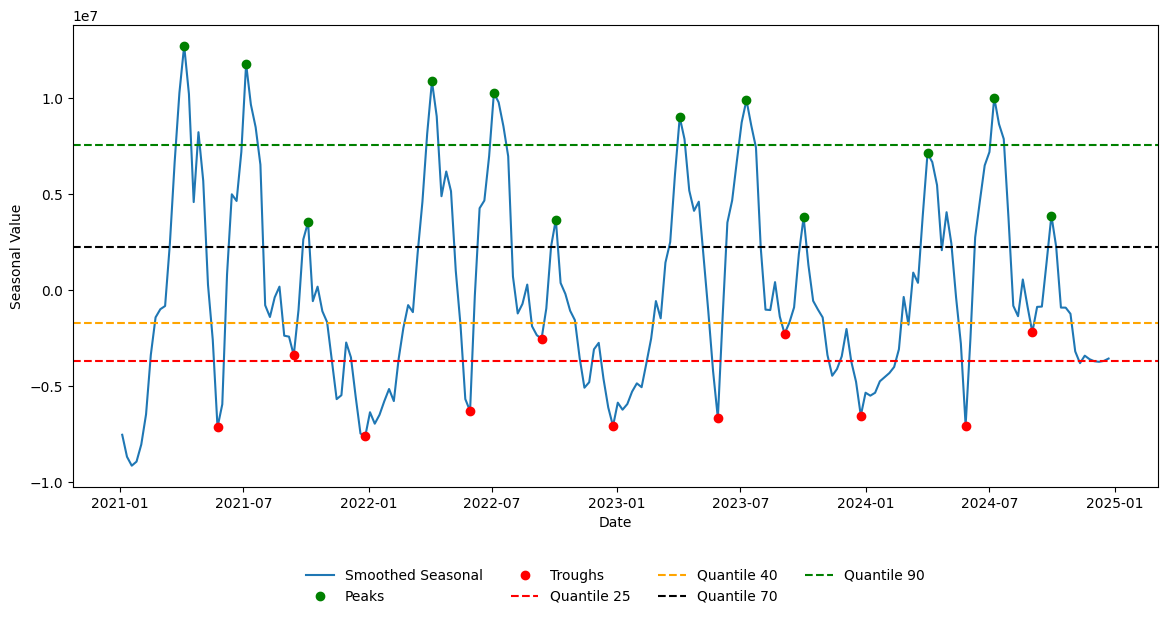

In [60]:
from scipy.signal import find_peaks

# STEP 3: Identify peaks and troughs in the smoothed seasonal component
# Use a prominence threshold to filter out insignificant peaks and troughs
# Calculate prominence based on the smoothed seasonal component
# This will help in identifying significant peaks and troughs

prominence = 0.2 * (smoothed_seasonal.max() - smoothed_seasonal.min())
peak_idxs, _ = find_peaks(smoothed_seasonal, prominence=prominence)
trough_idxs, _ = find_peaks(-smoothed_seasonal, prominence=prominence)

# 3️⃣ Mark them
plt.figure(figsize=(14, 6))
plt.plot(smoothed_seasonal, label='Smoothed Seasonal')
plt.plot(smoothed_seasonal.index[peak_idxs], smoothed_seasonal.iloc[peak_idxs], 'go', label='Peaks')
plt.plot(smoothed_seasonal.index[trough_idxs], smoothed_seasonal.iloc[trough_idxs], 'ro', label='Troughs')


plt.axhline(y=q25, color='red', linestyle='--', label= "Quantile 25")
plt.axhline(y=q40, color='orange', linestyle='--', label="Quantile 40")
plt.axhline(y=q70, color='black', linestyle='--', label="Quantile 70")
plt.axhline(y=q90, color='green', linestyle='--', label="Quantile 90")
plt.xlabel('Date')
plt.ylabel('Seasonal Value')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=False)
plt.show()

In [61]:
# STEP 4: Classify peaks and troughs into "high" and "small" categories
# Initialize a list to hold the phase labels for each point in the smoothed seasonal component
phases = [None] * len(smoothed_seasonal)
# Iterate through the identified peaks and troughs to classify them into categories based on the quantiles
for idx in peak_idxs:
    val = smoothed_seasonal.iloc[idx]
    if val >= q90:
        phase_label = 'high_peak'
        threshold_low = q90  # ≥ 90%
        threshold_high = np.inf  # no upper bound
    elif q70 <= val < q90:
        phase_label = 'small_peak'
        threshold_low = q70  # ≥ 70%
        threshold_high = q90  # but < 90%
    else:
        continue 
    # --- Identify whether surrounding points migh satisfied the threshold ---
    # --- Walk left and right until no long meeting threshold ---
    i = idx
    while (i >= 0 and 
           smoothed_seasonal.iloc[i] >= threshold_low and 
           smoothed_seasonal.iloc[i] < threshold_high):
        phases[i] = phase_label
        i -= 1

    i = idx + 1
    while (i < len(smoothed_seasonal) and 
           smoothed_seasonal.iloc[i] >= threshold_low and 
           smoothed_seasonal.iloc[i] < threshold_high):
        phases[i] = phase_label
        i += 1


for idx in trough_idxs:
    val = smoothed_seasonal.iloc[idx]

    if val <= q25:
        phase_label = 'high_trough'
        threshold_low = -np.inf  # no lower bound
        threshold_high = q25
    elif q25 < val <= q40:
        phase_label = 'small_trough'
        threshold_low = q25
        threshold_high = q40
    else:
        continue  
    # --- Identify whether surrounding points migh satisfied the threshold ---
    # --- Walk left and right until no long meeting thresholdd ---
    i = idx
    while i >= 0:
        v = smoothed_seasonal.iloc[i]
        if v >= threshold_low and v <= threshold_high:
            phases[i] = phase_label
            i -= 1
        else:
            break
    i = idx + 1
    while i < len(smoothed_seasonal):
        v = smoothed_seasonal.iloc[i]
        if v >= threshold_low and v <= threshold_high:
            phases[i] = phase_label
            i += 1
        else:
            break



In [62]:
# STEP 5: Classify the remaining points based on their values and derivatives
# Initialize the phases list with None for all points
# This will hold the phase labels for each point in the smoothed seasonal component
# Iterate through the smoothed seasonal component and classify the remaining points based on their values and derivatives
for i in range(len(smoothed_seasonal)):
    if phases[i] is not None:
        continue  # keep locked

    val = smoothed_seasonal.iloc[i]
    deriv = derivative_smoothed.iloc[i]
    if val < q25:
        phases[i] = 'high_trough'
    if q70<= val < q90:
        if deriv > 0:
            phases[i] = 'start_high_peak'
        elif deriv < 0:
            phases[i] = 'end_high_peak'

    elif q40 <= val < q70:
        if deriv > 0:
            phases[i] = 'start_small_peak'
        elif deriv < 0:
            phases[i] = 'end_small_peak'
    
    elif q25 < val <= q40:
        if deriv > 0:
            phases[i] = 'end_high_trough'
        elif deriv < 0:
            phases[i] = 'start_high_trough'

    


In [63]:
### Create a DataFrame to hold the smoothed seasonal component and its phases
# This DataFrame will contain the date, smoothed seasonal value, and the corresponding phase label
df_phases = pd.DataFrame({
    'date': smoothed_seasonal.index,
    'seasonal': smoothed_seasonal.values,
    'phase': phases  # your phase list: peak_high, small_low, start_peak_high, etc.
})


In [64]:
# Since the last point might not have a valid phase, we can assign it the same phase as the second to last point
# This is a common practice to ensure the last point has a valid phase label 
df_phases.loc[df_phases.index[-1], 'phase'] = df_phases.loc[df_phases.index[-2], 'phase']


/var/folders/g9/0qzz7y_x0hv9n3vm26f0d_2w0000gn/T/ipykernel_10869/3591540839.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_phases['phase'] = pd.Series(df_phases['phase']).fillna(method='ffill').fillna(method='bfill')
/var/folders/g9/0qzz7y_x0hv9n3vm26f0d_2w0000gn/T/ipykernel_10869/3591540839.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df_phases['phase'] = df_phases['phase'].replace('unknown', method='ffill').replace('unknown', method='bfill')


Unique phases: ['high_trough' 'end_high_trough' 'start_small_peak' 'start_high_peak'
 'high_peak' 'end_high_peak' 'end_small_peak' 'start_high_trough'
 'small_trough' 'small_peak']


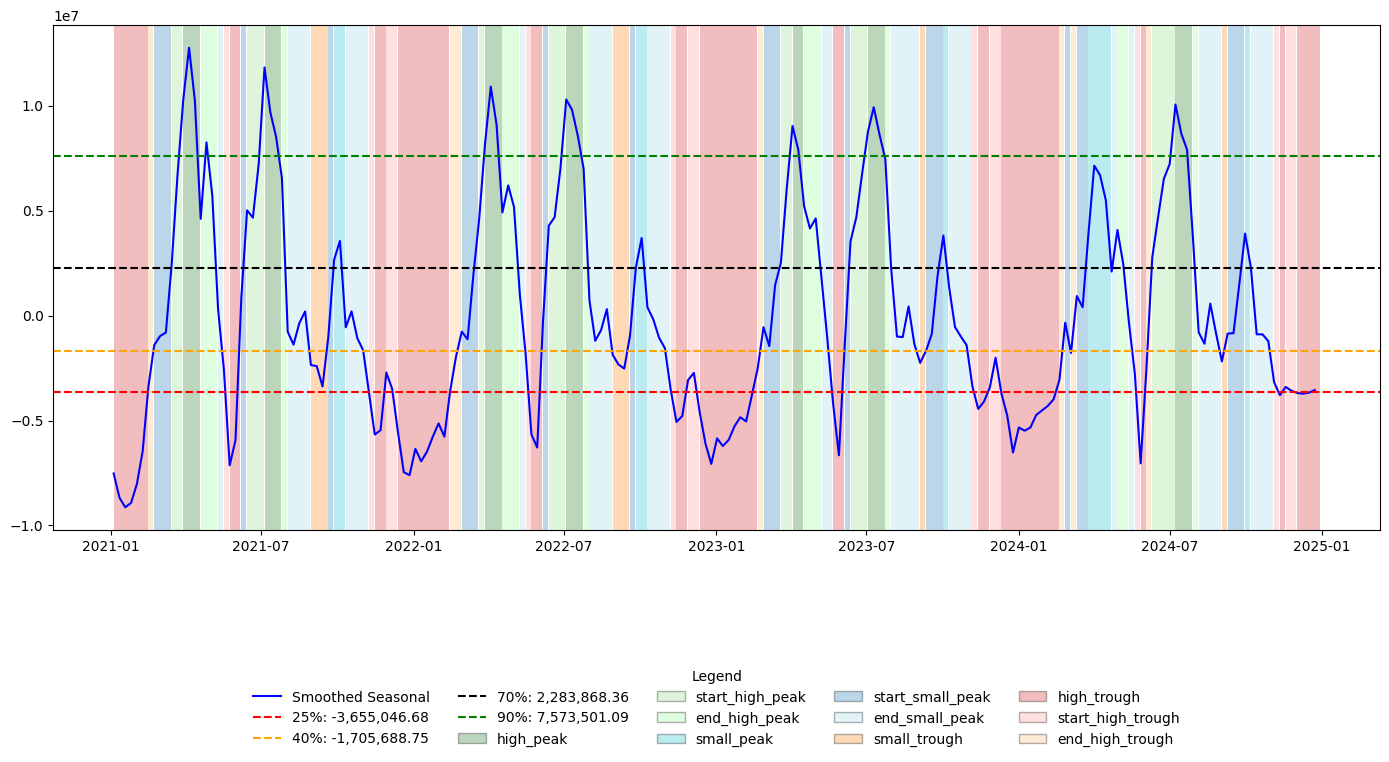

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
# Visualize the phases 

# Fill any None, NaN, or 'unknown' by forward & backward fill
df_phases['phase'] = pd.Series(df_phases['phase']).fillna(method='ffill').fillna(method='bfill')
df_phases['phase'] = df_phases['phase'].replace('unknown', method='ffill').replace('unknown', method='bfill')

# Confirm
print('Unique phases:', df_phases['phase'].unique())

# ----------------------------------------
# Group contiguous runs
# ----------------------------------------
df_phases['phase_run'] = (df_phases['phase'] != df_phases['phase'].shift()).cumsum()


# ----------------------------------------
# Define the colors 
# ----------------------------------------
colors = {
    'high_peak': '#1f7a1f',   # darker green
    'start_high_peak': '#98df8a',     # light green
    'end_high_peak': '#98FB98',  # medium green
    'small_peak': '#17becf',        # teal
    'start_small_peak': '#1f78b4',  # medium teal
    'end_small_peak': '#9edae5',    # pale teal
    'small_trough': '#ff7f0e',         # orange
    'high_trough': '#d62728',
    'start_high_trough': '#ff9896',    # light red
    'end_high_trough': '#ffbb78'        # pale orange     
}


# ----------------------------------------
# Plot with shading
# ----------------------------------------
plt.figure(figsize=(14, 8))

# Main seasonal line
plt.plot(df_phases['date'], df_phases['seasonal'], label='Smoothed Seasonal', color='blue')

# Draw shaded blocks for each run
for _, run in df_phases.groupby('phase_run'):
    phase = run['phase'].iloc[0]
    if phase in colors:
        start = run['date'].iloc[0]
        end = run['date'].iloc[-1] + pd.Timedelta(days=6)  # extend to week end

        plt.axvspan(start, end, facecolor=colors[phase], alpha=0.3)


plt.axhline(y=q25, color='red', linestyle='--', label=f'25%: {q25:,.2f}')
plt.axhline(y=q40, color='orange', linestyle='--', label=f'40%: {q40:,.2f}')
plt.axhline(y=q70, color='black', linestyle='--', label=f'70%: {q70:,.2f}')
plt.axhline(y=q90, color='green', linestyle='--', label=f'90%: {q90:,.2f}')

phase_patches = [
    Patch(facecolor=hex_color, edgecolor='k', label=phase,  alpha=0.3)
    for phase, hex_color in colors.items()
]
handles1, labels1 = plt.gca().get_legend_handles_labels()

# Combine: quantiles & line + phase colors
combined_handles = handles1 + phase_patches

# One combined legend BELOW the plot
plt.legend(handles=combined_handles,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.25),
           ncol=5,
           title='Legend',
           frameon=False)

plt.tight_layout()
plt.show()

In [66]:
# Merge the phases with the original DataFrame
# This will allow us to analyze the total sales in relation to the identified phases
# Ensure the 'date' column is in datetime format and set it as the index
df_phases.set_index('date', inplace=True)
df_phases = df_phases[['phase']]
df_uses1 = df[['total_sales']]  # Keep only the 'phase' column
merged_df = df_uses1.merge(df_phases, left_index=True, right_index=True, how='inner')
merged_df.head()

,total_sales,phase
2021-01-04,3686279.86,high_trough
2021-01-11,8965000.12,high_trough
2021-01-18,11766983.19,high_trough
2021-01-25,4926779.37,high_trough
2021-02-01,21646899.18,high_trough


In [67]:
# One-hot encode the 'phase' column
phase_dummies = pd.get_dummies(merged_df['phase'], prefix='phase')

# Concatenate the original DataFrame with the one-hot encoded columns
merged_df = pd.concat([merged_df, phase_dummies], axis=1)
merged_df.drop('phase_small_trough', axis=1, inplace=True)  # Drop the 'phase_small_low' column as the reference group

# Display the updated DataFrame
print(merged_df.head())

            total_sales        phase  phase_end_high_peak  \
2021-01-04   3686279.86  high_trough                False   
2021-01-11   8965000.12  high_trough                False   
2021-01-18  11766983.19  high_trough                False   
2021-01-25   4926779.37  high_trough                False   
2021-02-01  21646899.18  high_trough                False   

            phase_end_high_trough  phase_end_small_peak  phase_high_peak  \
2021-01-04                  False                 False            False   
2021-01-11                  False                 False            False   
2021-01-18                  False                 False            False   
2021-01-25                  False                 False            False   
2021-02-01                  False                 False            False   

            phase_high_trough  phase_small_peak  phase_start_high_peak  \
2021-01-04               True             False                  False   
2021-01-11               Tru

# Modelling

In [31]:
merged_df.columns

Index(['total_sales', 'phase', 'phase_end_high_trough', 'phase_high_peak',
       'phase_high_trough', 'phase_small_peak', 'phase_start_high_peak',
       'phase_start_small_peak'],
      dtype='object')

In [68]:
### Define target and exogenous variables
target_col = 'total_sales'
exo_col = ['phase_end_high_peak', 'phase_end_high_trough',
       'phase_end_small_peak', 'phase_high_peak', 'phase_high_trough',
       'phase_small_peak', 'phase_start_high_peak', 'phase_start_high_trough',
       'phase_start_small_peak']

### Split the data into training and testing sets
merged_df = merged_df.asfreq('W-Mon')
train_df = merged_df.loc[:'2024-06-24']
test_df = merged_df.loc['2024-06-24':]
test_df = test_df.iloc[1:]


In [69]:
# Function to calculate the Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [70]:
# Function to calculate the Root Mean Squared Error (RMSE)
def r_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

## ARIMA

### Baseline ARIMA

In [ ]:
### Baseline model fiting with order (20, 0, 3)

# Fit ARIMA model to the training data
arima_order = (20, 0, 3) 
model = ARIMA(train_df[target_col], order=arima_order)
results = model.fit()
# Forecast on the test set
forecast = results.forecast(steps=len(test_df[target_col]))

# Convert forecast to a pandas Series for easier handling
forecast_series = pd.Series(forecast, index=test_df.index)

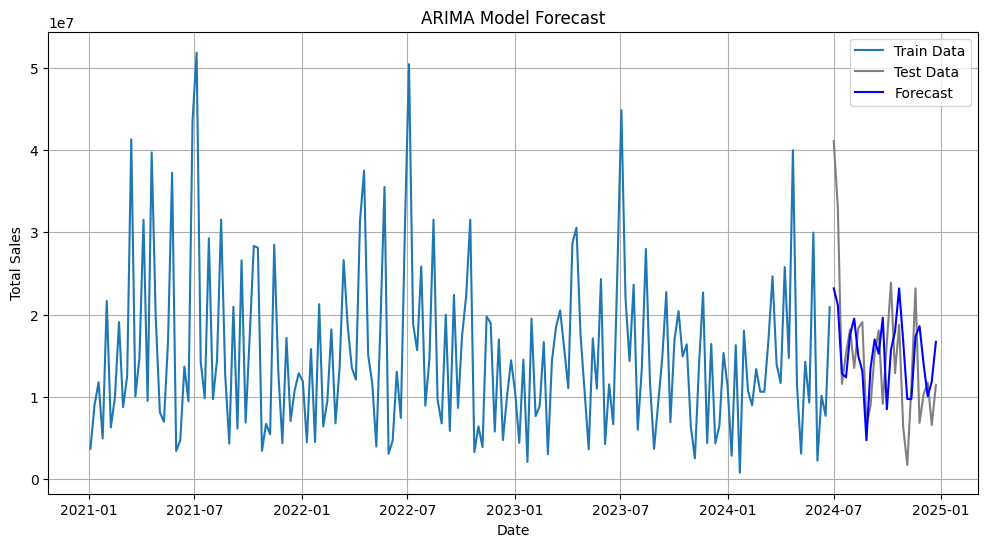

In [75]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='blue')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model performance
# Calculate MAPE and RMSE for the forecast
mape = mean_absolute_percentage_error(test_df[target_col], forecast_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], forecast_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 61.23%
RMSE: 7053986.14


### Optimal Parameters 

In [ ]:
# Grid search for ARIMA parameters
# This will help us find the best ARIMA parameters based on AIC

p = range(0, 21) #run from 0 to 20
d = [0]
q = range(0, 5) # #run from 0 to 4

parameters = list(product(p, d, q))
best_aic = float("inf")
best_params = None
best_model = None

# Grid search
for param in parameters:
    try:
        model = ARIMA(train_df[target_col], order=param)
        model_fit = model.fit()

        aic = model_fit.aic

        if aic < best_aic:
            best_aic = aic
            best_params = param
            best_model = model_fit

        print(f"Tested ARIMA{param} - AIC: {aic:.4f}")
    except Exception as e:
        print(f"ARIMA{param} failed: {e}")
        
# Print best parameters 
print("\nBest ARIMA parameters:", best_params)
print("Best AIC:", best_aic)

In [72]:
# Fit ARIMA model with optimal parameters
optimal_arima_order = (4, 0, 4)  
model = ARIMA(train_df[target_col], order= optimal_arima_order)
results = model.fit()
# Forecast on the test set
optimal_forecast = results.forecast(steps=len(test_df[target_col]))

# Convert forecast to a pandas Series for easier handling
forecast_optimal_series = pd.Series(optimal_forecast, index=test_df.index)

/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


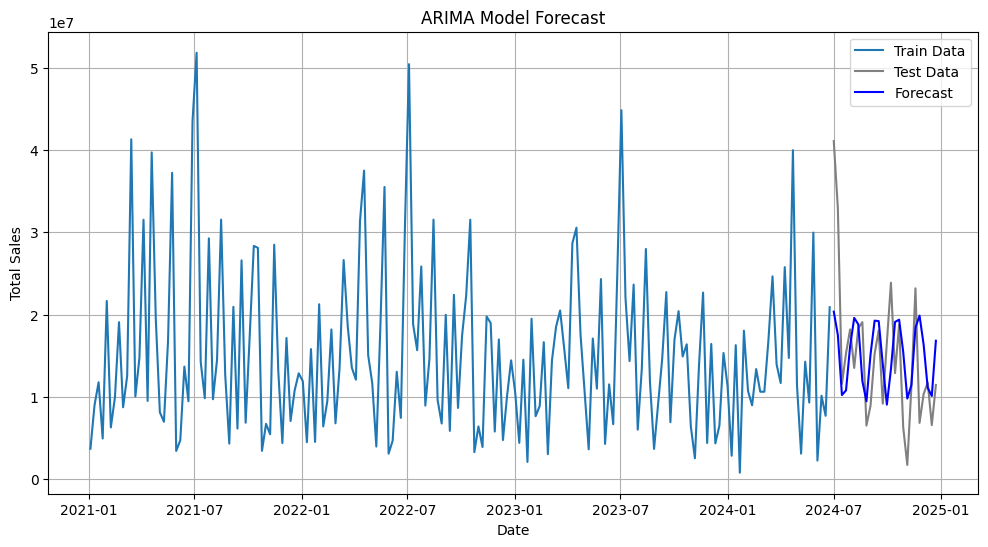

In [76]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(forecast_optimal_series.index, forecast_optimal_series, label='Forecast', color='blue')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluate the model performance
# Calculate MAPE and RMSE for the forecast
mape = mean_absolute_percentage_error(test_df[target_col], forecast_optimal_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], forecast_optimal_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 60.35%
RMSE: 7585453.26


## SARIMA

### Baseline (20,0,3)

In [ ]:
# Define SARIMA model parameters
sarima_order = (20, 0, 3)
seasonal_order = (1, 0, 1, 52)  # Assuming weekly seasonality (52 weeks per year)

# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_df[target_col], order=sarima_order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Forecast on the test set
sarima_forecast = sarima_results.forecast(steps=len(test_df))

# Convert forecast to a pandas Series for easier handling
sarima_forecast_series = pd.Series(sarima_forecast, index=test_df.index)

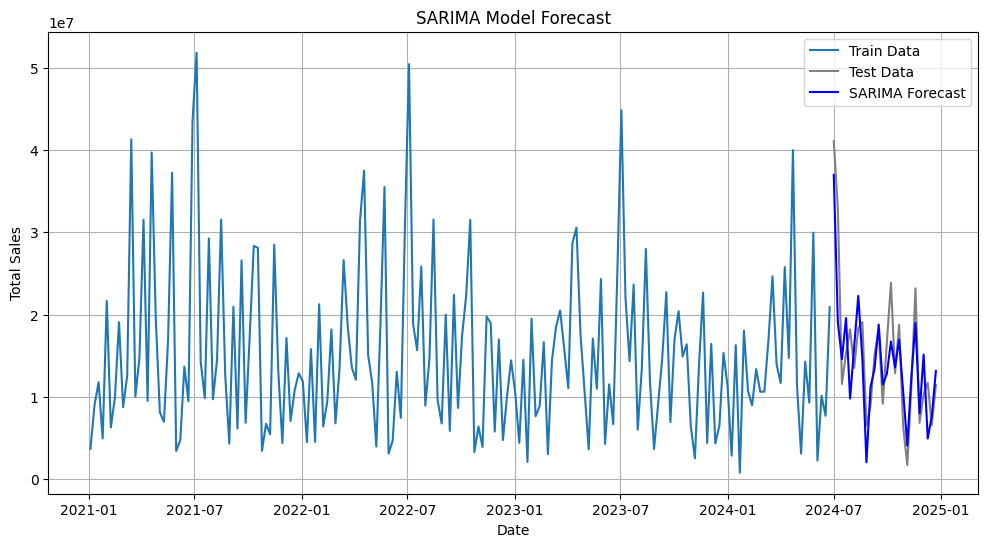

In [80]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(sarima_forecast_series.index, sarima_forecast_series, label='SARIMA Forecast', color='blue')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Evaluate the model performance
# Calculate MAPE and RMSE for the forecast
mape = mean_absolute_percentage_error(test_df[target_col], sarima_forecast_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], sarima_forecast_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 30.98%
RMSE: 4680202.93


### Optimal parameters

In [ ]:
# === 1️⃣ Your parameter ranges ===
p = range(0, 21)
d = [0]
q = range(0, 5)

P = range(0, 2)
D = [0]
Q = range(0, 2)
s = 52   # weekly data, so seasonal period is 52 weeks (1 year)

# === 2️⃣ Create parameter grid ===
parameters = list(product(p, d, q, P, D, Q))
print(f'Total parameter combinations: {len(parameters)}')

best_aic = float("inf")
best_params = None
best_model = None

# === 3️⃣ Grid search ===
for param in parameters:
    try:
        # Unpack
        p_, d_, q_, P_, D_, Q_ = param

        model = SARIMAX(
            train_df[target_col],
            order=(p_, d_, q_),
            seasonal_order=(P_, D_, Q_, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        aic = model_fit.aic

        if aic < best_aic:
            best_aic = aic
            best_params = param
            best_model = model_fit

        print(f"Tested SARIMA({p_},{d_},{q_}) x ({P_},{D_},{Q_},{s}) - AIC: {aic:.4f}")

    except Exception as e:
        print(f"SARIMA({param}) failed: {e}")

# Print best parameters 
print("\n Best SARIMA parameters:")
print(f"Non-seasonal: (p,d,q) = ({best_params[0]},{best_params[1]},{best_params[2]})")
print(f"Seasonal: (P,D,Q,s) = ({best_params[3]},{best_params[4]},{best_params[5]},{s})")
print(f"Best AIC: {best_aic:.4f}")

In [ ]:
# Define SARIMA model parameters
o_sarima_order = (9, 0, 4)
o_seasonal_order = (1, 0, 1, 52)  # Assuming weekly seasonality (52 weeks per year)

# Fit SARIMA model to the training data
o_sarima_model = SARIMAX(train_df[target_col], order=o_sarima_order, seasonal_order=o_seasonal_order)
o_sarima_results = o_sarima_model.fit()

# Forecast on the test set
o_sarima_forecast = o_sarima_results.forecast(steps=len(test_df))

# Convert forecast to a pandas Series for easier handling
o_sarima_forecast_series = pd.Series(o_sarima_forecast, index=test_df.index)

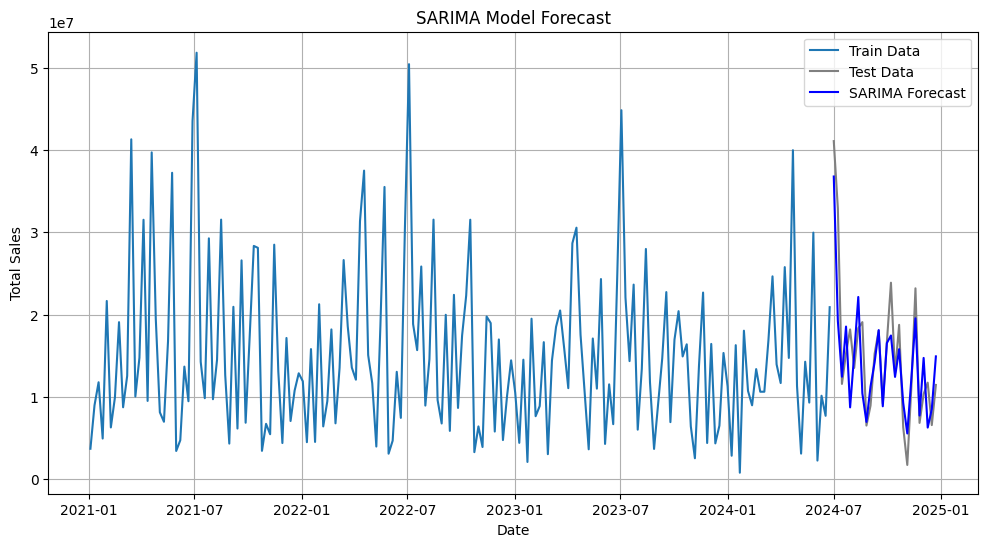

In [84]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(o_sarima_forecast_series.index, o_sarima_forecast_series, label='SARIMA Forecast', color='blue')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model performance
# Calculate MAPE and RMSE for the forecast
mape = mean_absolute_percentage_error(test_df[target_col], o_sarima_forecast_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], o_sarima_forecast_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 29.17%
MSE: 4639952.85


## ARIMAX 

### Baseline (20,0,3)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMAX model
arimax_order = (20, 0, 3)  # Example order (p, d, q)
model_arimax = SARIMAX(train_df[target_col], exog=train_df[exo_col], order=arimax_order)
results_arimax = model_arimax.fit()

# Forecast on the test set
forecast_arimax = results_arimax.forecast(steps=len(test_df), exog=test_df[exo_col])

# Convert forecast to a pandas Series for easier handling
forecast_arimax_series = pd.Series(forecast_arimax, index=test_df.index)

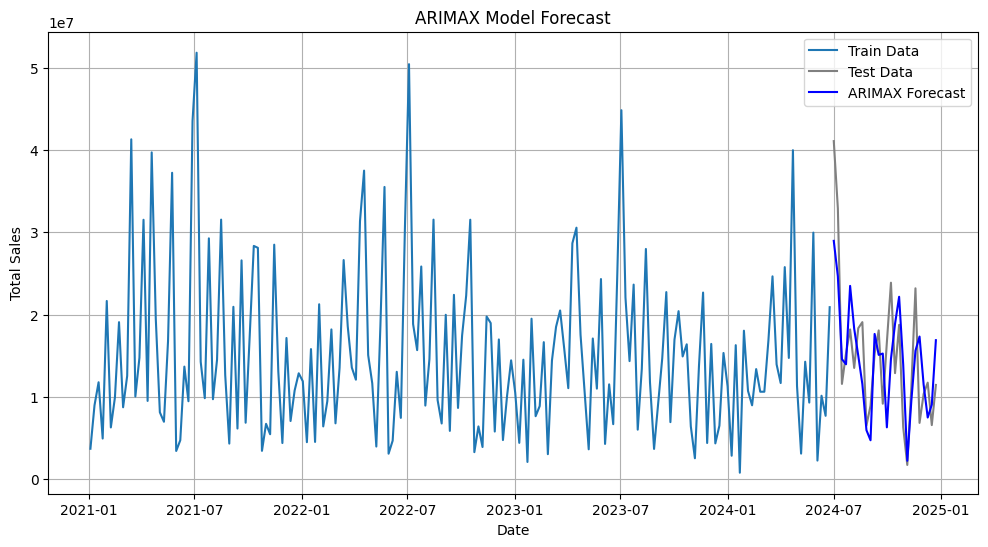

In [89]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(forecast_arimax_series.index, forecast_arimax_series, label='ARIMAX Forecast', color='blue')
plt.title('ARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# Evaluate the model performance
# Calculate MAPE and RMSE for the forecast
mape = mean_absolute_percentage_error(test_df[target_col], forecast_arimax_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], forecast_arimax_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 39.08%
RMSE: 6007995.83


In [ ]:
table = results_arimax.summary()
table 

### Optimal parameter

In [ ]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# ----------------------------------------
# ✅ 1) Define your grid
# ----------------------------------------
p = range(0, 21)  # 0 to 20 inclusive
d = [0]           # fixed
q = range(0, 5)   # 0 to 4 inclusive

parameters = list(product(p, d, q))
print(f"Total combinations: {len(parameters)}")

# ----------------------------------------
# ✅ 2) Grid search
# ----------------------------------------
best_aic = float("inf")
best_params = None
best_model = None

for param in parameters:
    try:
        p_, d_, q_ = param

        model = SARIMAX(
            train_df[target_col],
            exog=train_df[exo_col],
            order=(p_, d_, q_),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)

        aic = results.aic

        if aic < best_aic:
            best_aic = aic
            best_params = param
            best_model = results

        print(f"Tested ARIMAX({p_},{d_},{q_}) - AIC: {aic:.2f}")

    except Exception as e:
        print(f"ARIMAX({p_},{d_},{q_}) failed: {e}")

print("\n Best ARIMAX parameters:")
print(f"(p,d,q): ({best_params[0]},{best_params[1]},{best_params[2]})")
print(f"Best AIC: {best_aic:.2f}")

In [93]:
# Fit ARIMAX model
o_arimax_order = (20, 0, 4)  # Example order (p, d, q)
o_model_arimax = SARIMAX(train_df[target_col], exog=train_df[exo_col], order=o_arimax_order)
o_results_arimax = o_model_arimax.fit()

# Forecast on the test set
o_forecast_arimax = o_results_arimax.forecast(steps=len(test_df), exog=test_df[exo_col])

# Convert forecast to a pandas Series for easier handling
o_forecast_arimax_series = pd.Series(o_forecast_arimax, index=test_df.index)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73189D+01    |proj g|=  5.58191D-02

At iterate    5    f=  1.73128D+01    |proj g|=  2.21134D-02

At iterate   10    f=  1.73017D+01    |proj g|=  2.50660D-02

At iterate   15    f=  1.72980D+01    |proj g|=  2.13076D-02

At iterate   20    f=  1.72943D+01    |proj g|=  1.34366D-01

At iterate   25    f=  1.72899D+01    |proj g|=  2.78918D-02

At iterate   30    f=  1.72873D+01    |proj g|=  1.59250D-02

At iterate   35    f=  1.72858D+01    |proj g|=  1.59117D-02

At iterate   40    f=  1.72852D+01    |proj g|=  4.07465D-02

At iterate   45    f=  1.72849D+01    |proj g|=  5.48837D-03


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72849D+01    |proj g|=  3.35131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     61      1     0     0   3.351D-03   1.728D+01
  F =   17.284856212581506     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


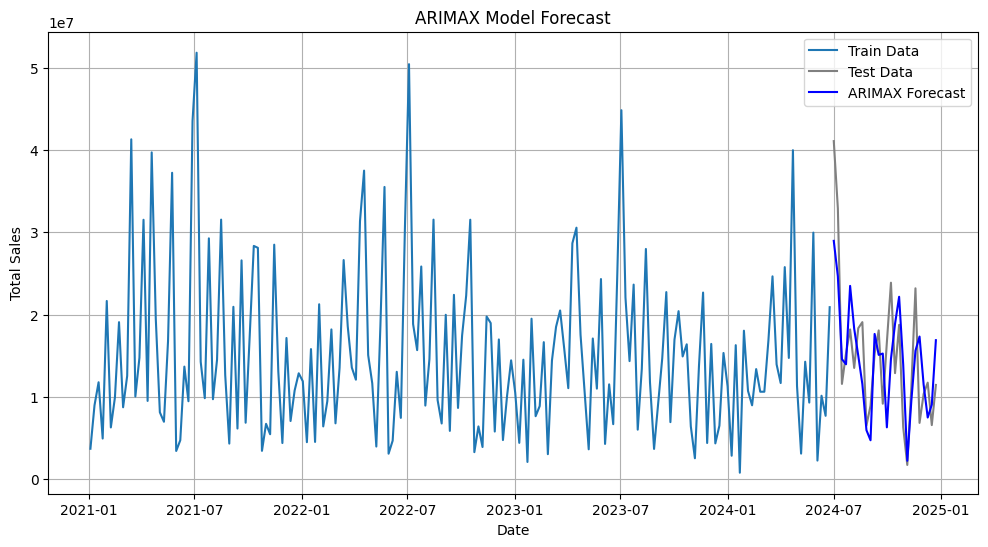

In [94]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(forecast_arimax_series.index, forecast_arimax_series, label='ARIMAX Forecast', color='blue')
plt.title('ARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
o_results_arimax.summary()

In [99]:
# Evaluate the model performance
# Calculate MAPE and RMSE for the forecast
mape = mean_absolute_percentage_error(test_df[target_col], o_forecast_arimax_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], o_forecast_arimax_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 40.65%
RMSE: 6603452.47


## Compare

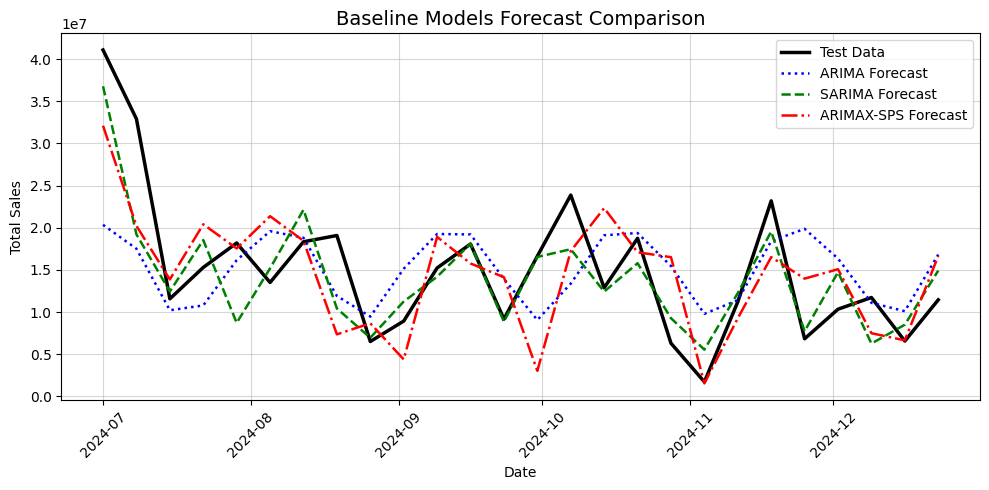

In [97]:
# Plotting the results of the baseline models
# This will help us visualize the performance of the ARIMA, SARIMA, and ARIMAX models on the test data
plt.figure(figsize=(10, 5))

#Plot actual test data as a thick solid line
plt.plot(
    test_df.index, 
    test_df[target_col], 
    label='Test Data', 
    color='black', 
    linewidth=2.5
)

# Plot ARIMA forecast (blue, dotted)
plt.plot(
    forecast_optimal_series.index, 
    forecast_optimal_series, 
    label='ARIMA Forecast', 
    color='blue', 
    linestyle=':',
    linewidth=1.8
)

#  Plot SARIMA forecast (green, dashed)
plt.plot(
    o_sarima_forecast_series.index, 
    o_sarima_forecast_series, 
    label='SARIMA Forecast', 
    color='green', 
    linestyle='--',
    linewidth=1.8
)

#  Plot ARIMAX forecast (red, dash-dot)
plt.plot(
    o_forecast_arimax_series.index, 
    o_forecast_arimax_series, 
    label='ARIMAX-SPS Forecast', 
    color='red', 
    linestyle='-.',
    linewidth=1.8
)

#  Add title and labels
plt.title('Baseline Models Forecast Comparison', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales')

# Format x-axis: rotate 
plt.xticks(rotation=45)

#  Add grid and legend
plt.grid(True, alpha=0.5)
plt.legend(loc='upper right', fontsize=10)

# ✅ 8) Tight layout for clean margins
plt.tight_layout()

# ✅ 9) Show plot
plt.show()


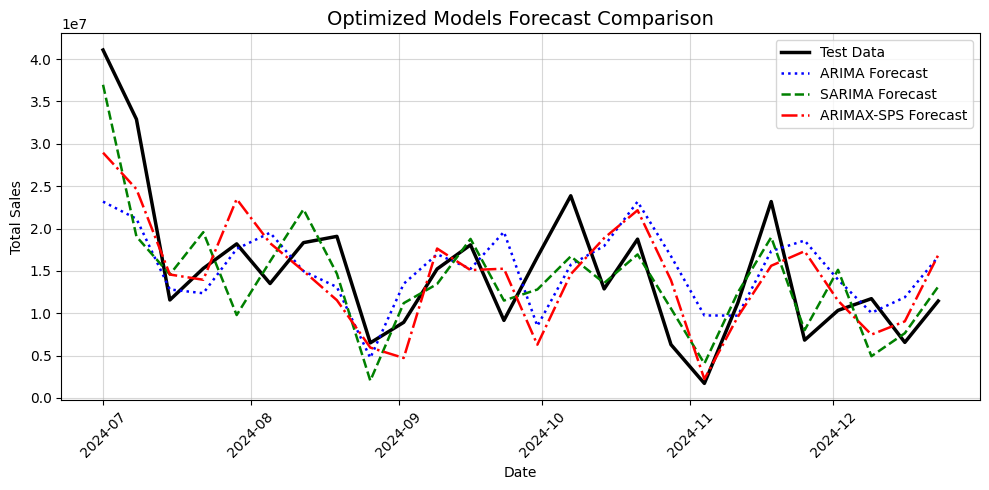

In [98]:
# Plotting the results of the optimized models
# This will help us visualize the performance of the ARIMA, SARIMA, and ARIMAX models on the test data
plt.figure(figsize=(10, 5))

# Plot actual test data as a thick solid line
plt.plot(
    test_df.index, 
    test_df[target_col], 
    label='Test Data', 
    color='black', 
    linewidth=2.5
)

# Plot ARIMA forecast (blue, dotted)
plt.plot(
    forecast_series.index, 
    forecast_series, 
    label='ARIMA Forecast', 
    color='blue', 
    linestyle=':',
    linewidth=1.8
)

# Plot SARIMA forecast (green, dashed)
plt.plot(
    sarima_forecast_series.index, 
    sarima_forecast_series, 
    label='SARIMA Forecast', 
    color='green', 
    linestyle='--',
    linewidth=1.8
)

# Plot ARIMAX forecast (red, dash-dot)
plt.plot(
    forecast_arimax_series.index, 
    forecast_arimax_series, 
    label='ARIMAX-SPS Forecast', 
    color='red', 
    linestyle='-.',
    linewidth=1.8
)

# Add title and labels
plt.title('Optimized Models Forecast Comparison', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales')

# Format x-axis: rotate and use nice date labels
plt.xticks(rotation=45)

# Add grid and legend
plt.grid(True, alpha=0.5)
plt.legend(loc='upper right', fontsize=10)

# Tight layout for clean margins
plt.tight_layout()

# Show plot
plt.show()
